NetCDF Global Attributes:
	Conventions: 'COARDS'
	title: 'mean daily NMC reanalysis (2012)'
	history: 'created 2011/12 by Hoop (netCDF2.3)'
	description: 'Data is from NMC initialized reanalysis\n(4x/day).  These are the 0.9950 sigma level values.'
	platform: 'Model'
	references: 'http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html'
NetCDF dimension information:
	Name: lat
		size: 73
		type: dtype('float32')
		units: 'degrees_north'
		actual_range: array([ 90., -90.], dtype=float32)
		long_name: 'Latitude'
		standard_name: 'latitude'
		axis: 'Y'
	Name: lon
		size: 144
		type: dtype('float32')
		units: 'degrees_east'
		long_name: 'Longitude'
		actual_range: array([   0. ,  357.5], dtype=float32)
		standard_name: 'longitude'
		axis: 'X'
	Name: time
		size: 366
		type: dtype('float64')
		units: 'hours since 1-1-1 00:00:0.0'
		long_name: 'Time'
		actual_range: array([ 17628096.,  17636856.])
		delta_t: '0000-00-01 00:00:00'
		standard_name: 'time'
		axis: 'T'
		avg_period: 

/usr/lib64/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/usr/lib64/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib64/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


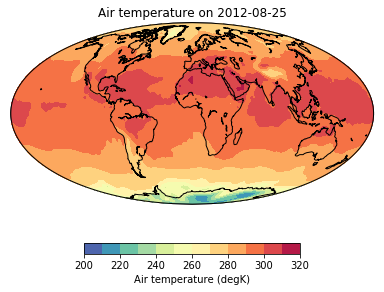

In [1]:
%matplotlib inline
import numpy as np
import datetime as dt
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

def ncdump(nc_fid, verb=True):
    def print_ncattr(key):
        try:
            print ("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print ('\t\t%s:' % ncattr, repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print ("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print ('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print ("NetCDF dimension information:")
        for dim in nc_dims:
            print ("\tName:", dim )
            print ("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print ("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print ('\tName:', var)
                print ("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print ("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

nc_f = 'air.nc'  # Your filename
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file
#############
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
# Extract data from NetCDF file
lats = nc_fid.variables['lat'][:]  # extract/copy the data
lons = nc_fid.variables['lon'][:]
time = nc_fid.variables['time'][:]
air = nc_fid.variables['air'][:]  # shape is time, lat, lon as shown above

time_idx = 237  # some random day in 2012
# Python and the renalaysis are slightly off in time so this fixes that problem
offset = dt.timedelta(hours=48)
# List of all times in the file as datetime objects
dt_time = [dt.date(1, 1, 1) + dt.timedelta(hours=t) - offset\
           for t in time]
cur_time = dt_time[time_idx]

# Plot of global temperature on our random day
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
# Setup the map. See http://matplotlib.org/basemap/users/mapsetup.html
# for other projections.
m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
# Make the plot continuous
air_cyclic, lons_cyclic = addcyclic(air[time_idx, :, :], lons)
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
air_cyclic, lons_cyclic = shiftgrid(180., air_cyclic, lons_cyclic, start=False)
# Create 2D lat/lon arrays for Basemap
lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
# Transforms lat/lon into plotting coordinates for projection
x, y = m(lon2d, lat2d)
# Plot of air temperature with 11 contour intervals
cs = m.contourf(x, y, air_cyclic, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label("%s (%s)" % (nc_fid.variables['air'].var_desc,\
                            nc_fid.variables['air'].units))
plt.title("%s on %s" % (nc_fid.variables['air'].var_desc, cur_time))

# Material de netcdf
## http://basemaptutorial.readthedocs.io/en/latest/basic_functions.html
## http://unidata.github.io/netcdf4-python/